In [32]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import scatter_matrix
from sklearn import neighbors, linear_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold
%matplotlib inline

## 1. Preparing data for classification

In [33]:
df_feature = pd.read_csv("./model_v24_feature_matrix_14.csv")
df_feature['id'] = df_feature['Unnamed: 0'].apply(lambda x: x.split('.')[0])
print (df_feature.shape)
df_feature.head()

(1434, 16)


,Unnamed: 0,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id
0,d777a77cc7a2ec2f1eed68799cc9075c.npz,0.697503,0.335968,0.385324,0.339156,0.148894,0.089260,0.385324,0.085551,0.021429,0.017857,0.010417,0.008194,0.007023,0.007828,d777a77cc7a2ec2f1eed68799cc9075c
1,1631637f08f27347e8f23d7a0e18c100.npz,0.666373,0.345718,0.391515,0.359679,0.148370,0.082181,0.391515,0.078761,0.000000,0.011111,0.006410,0.006998,0.005408,0.006810,1631637f08f27347e8f23d7a0e18c100
2,9065f2b133129c5747d42db18a424749.npz,0.701259,0.347774,0.394380,0.360565,0.159877,0.084858,0.394380,0.079833,0.018182,0.012121,0.022293,0.006912,0.005872,0.006968,9065f2b133129c5747d42db18a424749
3,e3a9a6f8d21c6c459728066bcf18c615.npz,0.690341,0.343430,0.400079,0.354308,0.147548,0.088106,0.400079,0.085576,0.007018,0.000000,0.015432,0.008045,0.006988,0.007040,e3a9a6f8d21c6c459728066bcf18c615
4,f39a1e54d79731e4417aa8159d19b7d4.npz,0.726764,0.341739,0.396748,0.356204,0.147422,0.088995,0.396748,0.086762,0.023529,0.017647,0.008621,0.007416,0.006616,0.006594,f39a1e54d79731e4417aa8159d19b7d4


In [34]:
df_labels = pd.read_csv('/home/lin/data/stage1_labels.csv')
print (df_labels.shape)
df_labels.head()

(1397, 2)


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1


In [35]:
df = pd.merge(left=df_feature, right=df_labels,how='outer',on='id').dropna()
print (df.shape)
df.head()

(1257, 17)


,Unnamed: 0,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
0,d777a77cc7a2ec2f1eed68799cc9075c.npz,0.697503,0.335968,0.385324,0.339156,0.148894,0.089260,0.385324,0.085551,0.021429,0.017857,0.010417,0.008194,0.007023,0.007828,d777a77cc7a2ec2f1eed68799cc9075c,1.0
1,1631637f08f27347e8f23d7a0e18c100.npz,0.666373,0.345718,0.391515,0.359679,0.148370,0.082181,0.391515,0.078761,0.000000,0.011111,0.006410,0.006998,0.005408,0.006810,1631637f08f27347e8f23d7a0e18c100,0.0
3,e3a9a6f8d21c6c459728066bcf18c615.npz,0.690341,0.343430,0.400079,0.354308,0.147548,0.088106,0.400079,0.085576,0.007018,0.000000,0.015432,0.008045,0.006988,0.007040,e3a9a6f8d21c6c459728066bcf18c615,0.0
4,f39a1e54d79731e4417aa8159d19b7d4.npz,0.726764,0.341739,0.396748,0.356204,0.147422,0.088995,0.396748,0.086762,0.023529,0.017647,0.008621,0.007416,0.006616,0.006594,f39a1e54d79731e4417aa8159d19b7d4,0.0
5,8987df2216ae2ab1a907d52bc9dc540d.npz,0.691301,0.342192,0.395080,0.358410,0.161766,0.087251,0.395080,0.083102,0.014286,0.017143,0.013699,0.006504,0.006538,0.007294,8987df2216ae2ab1a907d52bc9dc540d,0.0


## 2. Data exploration

### 2.1 Basic estadistics

+ How many patients do we have for training-test? --> 1257
+ How many cancer patients? --> 315
+ What percentage is the cancer patient? --> 25%


In [36]:
print ("data frame shape", df.shape)
print ("number of cancer patient:",df['cancer'].sum() )
print ("how un-balance is the data:", df['cancer'].sum()/df.shape[0])

data frame shape (1257, 17)
number of cancer patient: 315.0
how un-balance is the data: 0.25059665871121717


In [37]:
df_cancer = df.loc[df['cancer'] == 1]
print (df_cancer.shape)
df_cancer.head()

(315, 17)


,Unnamed: 0,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
0,d777a77cc7a2ec2f1eed68799cc9075c.npz,0.697503,0.335968,0.385324,0.339156,0.148894,0.089260,0.385324,0.085551,0.021429,0.017857,0.010417,0.008194,0.007023,0.007828,d777a77cc7a2ec2f1eed68799cc9075c,1.0
6,7c2b72f9e0f5649c22902292febdc89f.npz,0.668319,0.338826,0.384684,0.337507,0.154942,0.091774,0.384684,0.087845,0.003571,0.010714,0.017730,0.007094,0.006105,0.007789,7c2b72f9e0f5649c22902292febdc89f,1.0
10,f5717f7cbc08d8bd942cd4c1128e3339.npz,0.659050,0.350864,0.396342,0.361564,0.149278,0.087901,0.396342,0.083719,0.000000,0.002907,0.014286,0.007335,0.005666,0.007913,f5717f7cbc08d8bd942cd4c1128e3339,1.0
13,882107a204c302e27628f85522baea49.npz,0.644114,0.341161,0.386432,0.342413,0.152086,0.093578,0.386432,0.091503,0.006472,0.012945,0.022059,0.007439,0.006458,0.007329,882107a204c302e27628f85522baea49,1.0
16,35b9a3e9871499893f76c8e6c648562c.npz,0.730151,0.346685,0.396254,0.361175,0.168564,0.092978,0.396254,0.089513,0.000000,0.002740,0.016447,0.006256,0.005376,0.007318,35b9a3e9871499893f76c8e6c648562c,1.0


In [38]:
df_no_cancer = df.loc[df['cancer'] == 0]
print (df_no_cancer.shape)
df_no_cancer.head()

(942, 17)


,Unnamed: 0,max_malig,max_spiculation,max_lobulation,max_diameter,xsd_malig,xsd_spiculation,xmax_lobulation,xsd_diameter,loc_from_malig_x,loc_from_malig_y,loc_from_malig_z,std_locs_x,std_locs_y,std_locs_z,id,cancer
1,1631637f08f27347e8f23d7a0e18c100.npz,0.666373,0.345718,0.391515,0.359679,0.148370,0.082181,0.391515,0.078761,0.000000,0.011111,0.006410,0.006998,0.005408,0.006810,1631637f08f27347e8f23d7a0e18c100,0.0
3,e3a9a6f8d21c6c459728066bcf18c615.npz,0.690341,0.343430,0.400079,0.354308,0.147548,0.088106,0.400079,0.085576,0.007018,0.000000,0.015432,0.008045,0.006988,0.007040,e3a9a6f8d21c6c459728066bcf18c615,0.0
4,f39a1e54d79731e4417aa8159d19b7d4.npz,0.726764,0.341739,0.396748,0.356204,0.147422,0.088995,0.396748,0.086762,0.023529,0.017647,0.008621,0.007416,0.006616,0.006594,f39a1e54d79731e4417aa8159d19b7d4,0.0
5,8987df2216ae2ab1a907d52bc9dc540d.npz,0.691301,0.342192,0.395080,0.358410,0.161766,0.087251,0.395080,0.083102,0.014286,0.017143,0.013699,0.006504,0.006538,0.007294,8987df2216ae2ab1a907d52bc9dc540d,0.0
8,8a2de07f6e9dbb8c6e4bfad7e83b3f0a.npz,0.653820,0.343700,0.388062,0.350527,0.146453,0.086256,0.388062,0.082916,0.005464,0.013661,0.012987,0.006957,0.005452,0.007087,8a2de07f6e9dbb8c6e4bfad7e83b3f0a,0.0


### 2.2 Cancer patient v.s. Non-cancer patients

#### 2.2.1 Mean

<font color='red'> Does it make sense?? shouldn't be so similar!! </font>

In [56]:
df_cancer_mean = df.loc[df['cancer'] == 1].mean()
df_no_cancer_mean = df.loc[df['cancer'] == 0].mean()
print (df_cancer_mean-df_no_cancer_mean)

# plt.bar(y_pos, df_cancer_mean, align='center', alpha=0.5)

max_malig          -0.001229
max_spiculation     0.000453
max_lobulation      0.000456
max_diameter        0.000258
xsd_malig          -0.000767
xsd_spiculation     0.000010
xmax_lobulation     0.000456
xsd_diameter       -0.000008
loc_from_malig_x   -0.000510
loc_from_malig_y   -0.000363
loc_from_malig_z    0.000387
std_locs_x          0.000015
std_locs_y          0.000009
std_locs_z          0.000054
cancer              1.000000
dtype: float64


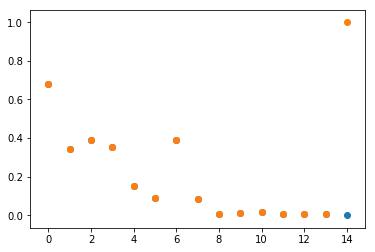

In [40]:
plt.scatter(np.arange(15),df_no_cancer_mean)
plt.scatter(np.arange(15),df_cancer_mean)

## 3. Feature selection, training-test splitting

In [221]:
from sklearn.preprocessing import StandardScaler

# x_cols = df.drop(['id', 'cancer', 'Unnamed: 0'],1).columns  # using all the features
x_cols=['max_malig','max_spiculation','max_lobulation','max_diameter',\
     'xsd_malig', 'xsd_spiculation', 'xmax_lobulation','xsd_diameter']
X = df.loc[:][x_cols].values
y = df.loc[:]['cancer'].values

print ("Feature space holds %d observations and %d features" % X.shape)
print ("Unique target labels:", np.unique(y))

Feature space holds 1257 observations and 8 features
Unique target labels: [ 0.  1.]


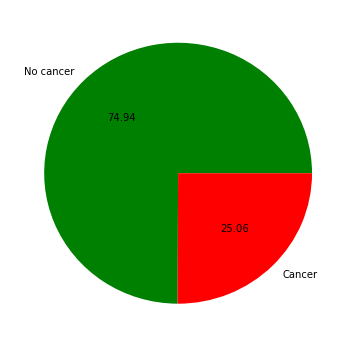

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.pie(np.c_[len(y)-np.sum(y),np.sum(y)][0],labels=['No cancer','Cancer'],colors=['g','r'],shadow=False,autopct ='%.2f' )
fig = plt.gcf()
fig.set_size_inches(6,6)

<div class = "alert alert-info">
**Unbalanced datasets**
<p>
In cancer detection because the cost of missing one patient in a trial is very large, we want the predictor to have very large recall/sensitivity (we do not accept false negatives) though it means accepting more false positives. These false positives can be discarded in subsequent tests. 

<p>
$$\text{sensitivity (recall) }=\frac{\text{TP}}{\text{Real Positives}}=\frac{\text{TP}}{\text{TP}+\text{FN}}$$


</div>

Although accuracy is the most normal metric for evaluating classifiers, there are cases when the business value of correctly predicting elements from one class is different from the value for the prediction of elements of another class. In those cases, accuracy is not a good performance metric and more detailed analysis is needed. The **confusion matrix** enables us to define different metrics considering such scenarios. The confusion matrix considers the concepts of the classifier outcome and the actual ground truth or gold standard. In a binary problem, there are four possible cases: 


+ *True positives (TP):* When the classifier predicts a sample as positive and it really is positive.
+ *False positives (FP):* When the classifier predicts a sample as positive but in fact it is negative.
+ *True negatives (TN):* When the classifier predicts a sample as negative and it really is negative.
+ *False negatives (FN):* When the classifier predicts a sample as negative but in fact it is positive.


We can summarize this information in a matrix, namely the confusion matrix, as follows:

<img src = "https://i.stack.imgur.com/OW5Lt.jpg" width = 400px>

### 3.1 Different classifiers

In [284]:
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesRegressor as XTR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

r_state = [0, 1,2,3,4,5,42,43,44,45]
acc = np.zeros((len(r_state),4))
recall = np.zeros((len(r_state),4))

for i in range(len(r_state)):

    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, train_size=0.7, random_state=r_state[i])
    
    # 1.decision tree
    clf_tr = tree.DecisionTreeClassifier() 
    clf_tr.fit(X_train,y_train)
    yhat_tr = clf_tr.predict(X_test)
    
    # 2.KNN1
    clf_nn1 = neighbors.KNeighborsClassifier(n_neighbors=1)      
    clf_nn1.fit(X_train,y_train)
    yhat_nn1 = clf_nn3.predict(X_test)
    
    # 3.Logistic regression
    lr = linear_model.LogisticRegression(class_weight={0:0.25,1:0.75},penalty='l1')
    lr.fit(X_train,y_train)
    yhat_lr = lr.predict(X_test)
    
    # 4.MLP
    mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=50, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-4, random_state=1,
                    learning_rate_init=.001)
    mlp.fit(X_train, y_train)
    yhat_mlp = mlp.predict(X_test)
    
    # accuracy score
    acc[i,0] = metrics.accuracy_score(y_test,yhat_tr)
    acc[i,1] = metrics.accuracy_score(y_test,yhat_nn1)
    acc[i,2] = metrics.accuracy_score(y_test,yhat_lr)
    acc[i,3] = metrics.accuracy_score(y_test,yhat_mlp)
    
    # recall score
    recall[i,0] = metrics.recall_score(y_test,yhat_tr)
    recall[i,1] = metrics.recall_score(y_test,yhat_nn1)
    recall[i,2] = metrics.recall_score(y_test,yhat_lr)
    recall[i,3] = metrics.recall_score(y_test,yhat_mlp)
    
    '''
    print ("Logistic regression:")
    print (confusion_matrix(y_test,yhat_lr))
    print (metrics.classification_report(y_test,yhat_lr))
    
     
    TP = np.sum(np.logical_and(yhat_lr==y_test,yhat_lr==1))
    TN = np.sum(np.logical_and(yhat_lr==y_test,yhat_lr==0))
    FP = np.sum(np.logical_and(yhat_lr!=y_test,yhat_lr==1))
    FN = np.sum(np.logical_and(yhat_lr!=y_test,yhat_lr==0))

    print (TP,FP)
    print (FN,TN)
    
    print ("recall: ", TP/(TP+FN) )            
    print ("precision: ", TP/(TP+FP))         
    print ("F1-score: ", 2*TP/(TP+FN+TP+FP))
    '''

/opt/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[ 0.26416383  0.30666763  0.55332172  0.17481668]


/opt/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: MatplotlibDeprecationWarning: The hold function was deprecated in version 2.0.


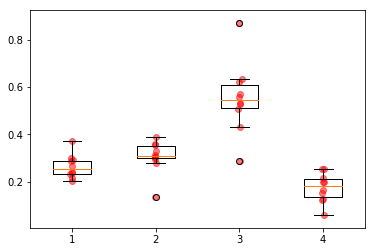

In [286]:
import matplotlib.pyplot as plt
fig = plt.figure()
# print (recall)
print (recall.mean(axis=0))
plt.boxplot(recall)
fig.hold('on')
plt.scatter(np.tile(np.array([1,2,3,4]),(10,1))+0.01*np.random.normal(size=(10,4)),recall,alpha = 0.5,color='r')

### SVM 

In [287]:
from sklearn import svm
from sklearn import cross_validation
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler

parameters = {'class_weight' : [{0:0.2},{0:0.25},{0:0.3}], 'C':[0.01,0.1,1.,10.]}

kf=cross_validation.KFold(n=y.shape[0], n_folds=5, shuffle=False, random_state=0)
recall = np.zeros((5,))
i=0
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    #Standard parameters
    clf = svm.LinearSVC()
    # We can change the scoring "average_precision", "recall", "f1"
    clf = grid_search.GridSearchCV(clf, parameters, scoring='recall')  # try all the combinations, and select the one with best performance
    clf.fit(X_train,y_train.ravel())
    X_test = scaler.transform(X_test)
    yhat[test_index] = clf.predict(X_test)
    #recall, f1, precision
    recall[i] = metrics.recall_score(yhat[test_index], y_test)
    print (str(clf.best_params_))
    i=i+1
print ('Mean recall: '+ str(np.mean(recall)))

{'class_weight': {0: 0.2}, 'C': 0.01}
{'class_weight': {0: 0.2}, 'C': 0.01}
{'class_weight': {0: 0.2}, 'C': 0.1}
{'class_weight': {0: 0.2}, 'C': 0.01}
{'class_weight': {0: 0.2}, 'C': 0.01}
Mean recall: 0.251035978176


In [288]:
print (metrics.classification_report(y_test, yhat[test_index]))
print (metrics.confusion_matrix( y_test,yhat[test_index]))

             precision    recall  f1-score   support

        0.0       1.00      0.01      0.01       179
        1.0       0.29      1.00      0.45        72

avg / total       0.80      0.29      0.14       251

[[  1 178]
 [  0  72]]


# DRAFT BELOW

- Try Tpot
- Try Random forest
- Understand XTR
- add some plots 

------

- The locs in this model is not correct!
- Katya's Updated model
- Maybe try Danniel's model too?
- How to combine different models?

In [291]:
print (y_test.sum(), y_test.shape, y_test.sum()/ y_test.shape)
print (y_train.sum(), y_train.shape, y_train.sum()/y_train.shape)

72.0 (251,) [ 0.28685259]
243.0 (1006,) [ 0.2415507]


In [290]:
print('LogisticRegression score: %f'% logistic.fit(X_train, y_train).score(X_test, y_test))

LogisticRegression score: 0.713147


In [289]:
confusion_matrix(y_test, logistic.predict(X_test))

array([[163,  16],
       [ 57,  15]])

In [40]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, Y)

for train_index, test_index in skf.split(X, Y):
#     print("TRAIN:", train_index, "\nTEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

print (X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)
mlp = MLPClassifier(hidden_layer_sizes=(500,500), max_iter=100, alpha=1e-4,
                    solver='adam', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.001)

(629, 14) (628, 14) (629,) (628,)


In [41]:
mlp.fit(X_train, Y_train)
print("Training set score: %f" % mlp.score(X_train, Y_train))
print("Test set score: %f" % mlp.score(X_test, Y_test))

Iteration 1, loss = 0.62881341
Iteration 2, loss = 0.56752884
Iteration 3, loss = 0.57459232
Iteration 4, loss = 0.56527411
Iteration 5, loss = 0.56680666
Iteration 6, loss = 0.57069154
Iteration 7, loss = 0.56855063
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Training set score: 0.748808
Test set score: 0.750000


In [42]:
mlp.predict_proba(X_train)

array([[ 0.72833808,  0.27166192],
       [ 0.72831089,  0.27168911],
       [ 0.72960447,  0.27039553],
       ..., 
       [ 0.72936873,  0.27063127],
       [ 0.72906942,  0.27093058],
       [ 0.73275669,  0.26724331]])

In [43]:
mlp.score(X_train, Y_train)

0.74880763116057236

In [44]:
sum(mlp.predict(X_test))

0.0

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, mlp.predict(X_test))

array([[471,   0],
       [157,   0]])